# Dimensionality Reduction, part 1

<a rel="license" href="https://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**: 
- Dr Antonia Mey (antonia.mey@ed.ac.uk)
- Dr Matteo Degiacomi (matteo.t.degiacomi@durham.ac.uk)

Content is partially adapted from the [Software Carpentries Machine learning lesson](https://carpentries-incubator.github.io/machine-learning-novice-sklearn/index.html) and material from the [pyEMMA tutorial](http://www.emma-project.org/latest/tutorials/notebooks/02-dimension-reduction-and-discretization.html).

**Questions:**
How can we perform unsupervised learning with dimensionality reduction techniques such as Principal Component Analysis (PCA), time-correlated independent component analysis (tICA), and t-distributed Stochastic Neighbor Embedding (t-SNE)?

**Objectives:**
- Remember that most data is inherently multidimensional
- Understand that reducing the number of dimensions can simplify modelling and allow classifications to be performed.
- Use PCA as a popular technique for dimensionality reduction.
- Use tICA another popular dimensionality reduction technique that takes time correlations into account
- t-SNE is another technique for dimensionality reduction.
- Apply PCA and t-SNE with Scikit Learn to an example dataset.
- Compare how PCA and tICA perform on a 2-D toy example
- Evaluate the relative performance of PCA and t-SNE.

**Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

# 1. Introduction

Scientific data, such as that extracted from molecular dynamics simulations, can be high-dimensional and noisy. Dimensionality reduction is the process identifying and highlighting information and correlations within the data. There are multiple reasons why you might want to do a dimensionality reduction.

- You might want to know what are the dominant features in your system (larger scale variations in data).
- You want a way to visualise your high dimensional data. 
- You want to analyse your data, but it it too high-dimensional.

The algorithms designed to carry out this task are an example of machine learning. In this tutorial we will look at Principal Components Analysis (PCA), time-lagged independent component analysis (tICA), and t-tested Stocastic Neighbour Embedding (t-SNE). In a machine learning context, each dimension in data is called a **feature**, which together form a **feature space**. 

<div class="alert alert-success">
<b>Task 1:</b> Can you think of examples of features that you would find in molecular simulations?</div>

<details>
<summary> <mark> Solution: </mark> </summary>

Examples are:
- C-alpha positions
- angles
- dihedrals
- RMSD
- density
- surface area
- ...

</details>

## 2. Principal Components Analysis (PCA)

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is an orthogonal linear transformation that transforms high dimensional data (or feature vectors) into a new coordinate system. In this coordinate system the first coordinate (first *eigenvector*) corresponds to the scalar projection of a linear combination of some data such that this coordinate has the largest variance. The second largest variance in the data can be found in the second coordinate and so on. Let's start by importing some packages required for the our analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Now, let's create some model data to analyse. To this end, we will exploit the Müller-Brown potential.

In [ ]:
def muller_potential(x, y):
    """Muller potential
    
    Parameters
    ----------
    x : {float, np.ndarray}
        X coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    y : {float, np.ndarray}
        Y coordinate. Can be either a single number or an array. If you supply
        an array, x and y need to be the same shape.
    Returns
    -------
    potential : {float, np.ndarray}
        Potential energy. Will be the same shape as the inputs, x and y.
    
    Reference
    ---------
    Code adapted from https://cims.nyu.edu/~eve2/ztsMueller.m
    """
    
    aa = [-1, -1, -6.5, 0.7]
    bb = [0, 0, 11, 0.6]
    cc = [-10, -10, -6.5, 0.7]
    AA = [-200, -100, -170, 15]
    XX = [1, 0, -0.5, -1]
    YY = [0, 0.5, 1.5, 1]
    
    value = 0
    for j in range(0, 4):
        value += AA[j] * np.exp(aa[j] * (x - XX[j])**2 + \
            bb[j] * (x - XX[j]) * (y - YY[j]) + cc[j] * (y - YY[j])**2)
    return value



We will now evaluate the potential on a 2-D grid, and plot visualize it.

In [ ]:
dims = (500, 500)
x = np.linspace(-1.5, 1, dims[0])
y = np.linspace(-0.4, 1.8, dims[1])
X, Y = np.meshgrid(x, y)
potential = muller_potential(X, Y)

levels = np.linspace(np.min(potential), np.max(potential), 50)
plt.contour(X, Y, potential.clip(max=200), 40);

Now, let's convert our potential into a probability distribution, and plot the result.

In [ ]:
Z = np.sum(np.exp(-1/25*potential)) #partition function
P = np.exp(-1/25*potential)/Z

plt.contour(X, Y, P, 100);

It's time to generate some data! We will extract 10000 samples according to the probability distribution we have just created. To this end, we will use np.random.choice, which enables us to generate random samples according to a given probability. Since this method works only in 1-D, we will first flatten the array, generate the samples, and them bring them back to 2-D.



In [ ]:
flat = np.ravel(P)
sample_index = np.random.choice(a=flat.size, p=flat, size=10000)
samples = np.unravel_index(sample_index, P.shape)
data = np.array([x[samples[1]], y[samples[0]]]).T

plt.scatter(data[:, 0], data[:, 1], c="r", alpha=0.05);

In [ ]:
np.shape(data)

PCA can tell us in which features (here the x coordinate is one feature and the y coordinate is the second feature), or rather which linear combination, carries the most variance. Let's do a PCA of the samples we have created.

In [ ]:
pca = PCA(n_components=2)
pca.fit(data)


PCA has identified the two eigenvectors (principal components) of our dataset. Here they are:

In [ ]:
print(pca.components_)

Each component represents a percentage of the total variance of the system. Here is how:

In [ ]:
print(pca.explained_variance_ratio_)


It is clear that the first component represents majority of the variance in the data. We have identified the two eigenvectors of this dataset. We can now plot them along with the data. To make arrows visible, we will scale their length by the explained variance of each eigenvector.



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data[:,0], data[:,1], c="r", alpha=0.05)

# plot arrows representing the two components
e1_x = pca.components_[0, 0]*pca.explained_variance_ratio_[0]
e1_y = pca.components_[0, 1]*pca.explained_variance_ratio_[0]
e2_x = pca.components_[1, 0]*pca.explained_variance_ratio_[1]
e2_y = pca.components_[1, 1]*pca.explained_variance_ratio_[1]
ax.arrow(np.mean(x), np.mean(y), e1_x/pca.explained_variance_ratio_[0], e1_y/pca.explained_variance_ratio_[0], head_width=0.1, head_length=0.1, fc='k', ec='k')
ax.arrow(np.mean(x), np.mean(y), e2_x/pca.explained_variance_ratio_[0], e2_y/pca.explained_variance_ratio_[0], head_width=0.1, head_length=0.1, fc='k', ec='k');

We can project the data on the new reference system defined by the principal components.

In [ ]:
data_projected = data.dot(pca.components_) + pca.mean_
print(data_projected)

<div class="alert alert-success">
<b>Task 2: </b> Can you use the PCA results to generate an 1-D approximate for the Müller-Brown potential?
</div>

<details>
<summary> <mark> Solution</mark> </summary>

The first principal component represents most of the variance, so we can observe the distribution of data only along this components. This is a way of using PCA as a way of filtering noise, and highlight dominant structures in your data.
    
```Python
plt.hist(data_projected[:,0], bins=50, color="r");
```

</details>

## 3. The MNIST Dataset

The MNIST dataset consists of a 60,000 examples of hand written numbers and 10,000 test set examples. The digits have all been resized to the same size and centered within this fixed image size. One way of accessing the data is from [here](http://yann.lecun.com/exdb/mnist/) or we can use built in function with scikit-learn. In this way you will access a reduced part of the dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import datasets
from sklearn import manifold

digits = datasets.load_digits()

# Examine the dataset
print(digits.data)
print(digits.target)

X = digits.data
y = digits.target

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


A short helper function to plot an example from the dataset:

In [ ]:
import matplotlib.pyplot as plt


def plot_digits(X):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((8, 8)), cmap="Greys")
        ax.axis("off")

In [ ]:
plot_digits(X)

<div class="alert alert-success">
<b>Task 3:</b> Understanding the dataset

- What are the dimensions of the data?
- What are the features of the data?
- What information do the features hold?

In [ ]:
### Your solution here:


<details>
<summary> <mark> Solution: </mark> </summary>

```Python
    
# data dimension
np.shape(X)
# The output of the array tells you, that you have 1797 samples of a 64 dimensional feature vector
  
# Features
print(X[0])
# Each entry in the first sample of the feature vector gives you a value of the grey scale from the image. This could be normalised.
```


</details>

<div class="alert alert-success">
<b>Task 4:</b> Can you do a principal component analysis of the digits dataset?

- Do a PCA analysis using two components.    
     - What is the variance contribution of the first two components?    
     - How many components do you need to reach 90% variance explained?    
- Generate a plot of the first two principal components and colour them according to your digit. What does it tell you? </div>

In [ ]:
### Your solution here:


<details>
<summary> <mark> Solution: </mark> </summary>

```Python
    
# PCA
pca = decomposition.PCA(n_components=2, n_oversamples=20)
pca.fit(X)
X_pca = pca.transform(X)

# variance contribution of first two components 
print(pca.explained_variance_ratio_)

# finding 90% variance
for i in range(2,30):
    pca = decomposition.PCA(n_components=i, n_oversamples=20)
    pca.fit(X)
    X_pca = pca.transform(X)
    cum_sum = pca.explained_variance_ratio_.cumsum()
    if cum_sum[-1] > 0.9:
        print(f'{i} number of principle components are needed to reach a variance explained of 90%')
        break

# plotting first two components and colouring according to digits
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.nipy_spectral, 
        edgecolor='k',label=y)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel('pc 1')
plt.ylabel('pc 2') 
```


</details>

<div class="alert alert-success">
<b>Task 5: </b> Rerun your PCA with 5 components </div>

What feature in your 64 (8x8) digit input vector contributes the most to your first principle components? 
Hint: look at the absolute value of `pca.components_[0]` If you you generate a bar plot you can see the contributions well.

In [ ]:
### Your solution here:



<details>
<summary> <mark> Solution: </mark> </summary>

```Python
pca = decomposition.PCA(n_components=5, n_oversamples=20)
pca.fit(X)
X_pca = pca.transform(X)
fig, ax = plt.subplots(figsize=(15,15))
indeces = np.argsort(abs(pca.components_[0]))
x = np.linspace(0,len(indeces), len(indeces))
ax.bar( x,abs(pca.components_[0])[indeces],tick_label=indeces)
ax.set_xlabel('feature index')
ax.set_ylabel('absolute value of contribution')
```


</details>

## 4. time-lagged independent component analysis (tICA)

In this section, we will study tCA with a toy dataset. Let's start by loading it.

In [11]:
# loading data
filename = 'data/hmm-doublewell-2d-100k.txt'
data = np.loadtxt(filename)

### 4.1. Visualising the dataset
We can see this is a trajectory with 100000 time datapoints and 2 features. Let's examine this dataset a bit more. 

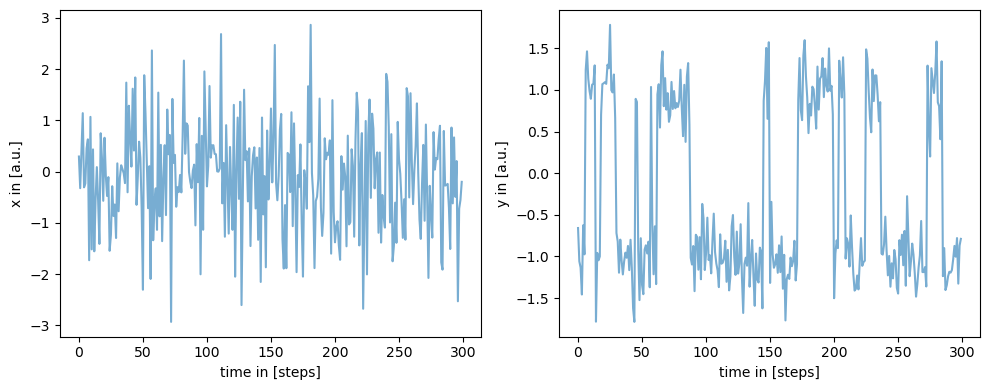

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(data[:300,0], alpha=0.6)
axes[1].plot(data[:300,1], alpha=0.6)
axes[1].set_xlabel('time in [steps]')
axes[0].set_xlabel('time in [steps]')
axes[0].set_ylabel('x in [a.u.]')
axes[1].set_ylabel('y in [a.u.]')
fig.tight_layout()

<div class="alert alert-success">
<b>Task 6: </b> Examine the data a bit more, to get a better feel for it. What is the extent of the data set in x and y? Can you plot a histogram of the data? What information does the trajectory tell us the histogram obscures? </div>



<details>
<summary> <mark> Solution: </mark> </summary>

The minimum and maximum of the data is given by:

```Python
print('x_min is:',np.min(data[:,0]), 'x_max is:',np.max(data[:,0]), '\ny_min is:', np.min(data[:,1]), 'y_max is:', np.max(data[:,1]))

```

An example of how to plot a histogram of the data looks like this:
    
```Python

plt.figure(figsize=(7,7))
counts,ybins,xbins = np.histogram2d(data[:,0],data[:,1],bins=250);
plt.contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()])
```
There is no slow transitions in the x coordinate, but there are in the y coordinate.

</details>

### 4.2. tICA analysis

tICA is a common dimensionality reduction technique for molecular dynamics trajectories. Unfortunately scikit-learn does not feature an implementation of this method, which is why other packages are normally used. Here, we provide a convenient helper module based on the implementation from [MSM-Builder](http://msmbuilder.org/3.8.0/), adapted so that it can be used as stand-alone code. The module is written so as to mimic the dimensionality reduction is done with scikit-learn. That means you use a similar syntax as before, i.e you create an instance of tICA with a given number of components and then you use fit and transform on the data. 

In [ ]:
from tica.tica import tICA

Let's carry out a tICA analysis of the data we have previously loaded. A small difference from the syntax in scikit-learn: the parameter of the <code>fit</code> method data must be in square brackets, since the method can accept a list of trajectory data.

In [ ]:
tic = tICA()
tic.fit([data]);

The dimensions identified by the tICA analysis can be accessed as follows:

In [ ]:
print(tic.eigenvectors_)

Time for the next excercise! Before getting to it though, execute the cell below, you will need it!

In [ ]:
def draw_arrow(origin, v, color):
    ax.arrow(origin[0], origin[1], v[0], v[1], color=color, width=0.02, linewidth=3)

<div class="alert alert-success">
<b>Task 7: </b> Now use PCA on the same dataset and compare the two components by creating a scatter plot and drawing the vectors representing the PCA composition and tICA composition. Make use of the handy helper function <code>draw_arrow</code> for the vectors to draw arrows on the scatter plot from above. </div>

In [ ]:
### Your solution here:



<details>
<summary> <mark> Solution: </mark> </summary>

We start by carrying out the PCA of the toy data
```Python
pca = PCA()
pca.fit(data);
```

Now, we plot a scatterplot of data, with arrows representing the first components of both tICA (red) and PCA (blue).

```Python
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(data[:,0], data[:,1], marker = '.', color='black', alpha=0.1)

origin = np.mean(data, axis=0)
draw_arrow(origin, tic.eigenvectors_[0]*2, "red")
draw_arrow(origin, pca.components_[0]*2, "dodgerblue")

ax.set_xlabel("x")
ax.set_ylabel("y");
```

</details>

### 4.3. Comparison of dimensionality reduction with PCA and tICA

Dimensionality reduction techniques enable us to identify suitable ways of projecting high-dimensional data into a lower-dimensional space with minimal information loss. We have just seen that PCA and tICA identify different spaces onto which the data can be projected.

<div class="alert alert-success">
<b>Task 5: </b>Project the data into the eigenspace generated by PCA, and into the tICA space. Create histograms of each of the components. What do you observe? </div>

In [ ]:
### Your solution here:



<details>
<summary> <mark> Solution: </mark> </summary>

Let's project the data into the tICA and PCA spaces.
    
```Python    
tic_out = tic.transform([data])[0]
PCA_out = pca.transform(data)
```
    
Now, let's make some pretty plots showing the projections on the first and second component of PCA and tICA
    
```Python
fig = plt.figure(figsize=(10, 4))
    
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(tic_out[:, 0], histtype="step", label="tICA", bins=50, color="red")
ax1.hist(PCA_out[:, 0], histtype="step", label="PCA", bins=50, color="dodgerblue")
ax1.set_xlabel("first component")
ax1.set_ylabel("count (#)")
ax1.legend(frameon=False);

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(tic_out[:, 1], histtype="step", label="tICA", bins=50, color="red")
ax2.hist(PCA_out[:, 1], histtype="step", label="PCA", bins=50, color="dodgerblue")
ax2.set_xlabel("second component")
ax2.legend(frameon=False);
```

</details>

## 5. t-Distributed Stochastic Neighbor Embedding (t-SNE) 

t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It gives each datapoint a poisition in a two or three dimensional map. It is classed as a non-linear dimensionality reduction technique and models high-dimensional data that are close in space to spatially close two or three-deminsional points. Let's apply t-SNE to the MNIST dataset we have met in section 3!

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state = 0)
X_tsne = tsne.fit_transform(X)
fig = plt.figure(1, figsize=(4, 4))
plt.clf()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.nipy_spectral,
        edgecolor='k',label=y)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.xlabel('tsne 0')
plt.ylabel('tsne 1')

<div class="alert alert-success">
<b>Task 6:</b> Can you regenerate your t-SNE embedding in 3D and plot it? </div>

In [ ]:
### Your solution here


<details>
<summary> <mark> Solution:</mark> </summary>

```Python
tsne = manifold.TSNE(n_components=3, init='pca', random_state = 0)
X_tsne = tsne.fit_transform(X)
fig = plt.figure(1, figsize=(4, 4))
plt.clf()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap=plt.cm.nipy_spectral, s=9, lw=0)

```
</details>

## 6. Conclusion

<div class="alert alert-info">
<b>Key points:</b>

- PCA is a linear dimensionality reduction technique for tabular data,
- PCA can be used to remove noise from data,
- tICA is also a linear dimensionality reduction technique, but it maximises the autocorrelation time rather than the variance    
- tICA and PCA may be appropriate for different use cases: tICA will generally provide you with slow dynamics and PCA for maximising spacial variance. 
- t-SNE is another dimensionality reduction technique for tabular data that is more general than PCA.
</div>

### Next Notebook

[Dimensionality Reduction, part 2](2_DR_part2.ipynb)

--------